In [1]:
import numpy
from matplotlib import pyplot, rcParams
%matplotlib inline
import matplotlib.cm as cm
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16
from matplotlib import animation
from IPython.display import HTML

In [2]:
# load initial conditions
uvinitial = numpy.load('./uvinitial.npz')
Ui = uvinitial['U']
Vi = uvinitial['V']

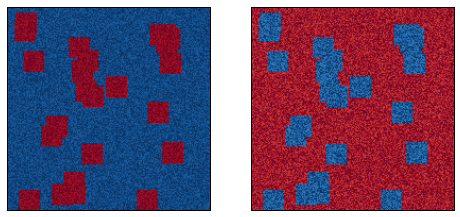

In [3]:
# plot initial condition
fig = pyplot.figure(figsize=(8,5))
pyplot.subplot(121)
pyplot.imshow(Ui, cmap = cm.RdBu)
pyplot.xticks([]), pyplot.yticks([]);
pyplot.subplot(122)
pyplot.imshow(Vi, cmap = cm.RdBu)
pyplot.xticks([]), pyplot.yticks([]);

In [4]:
# discretization and parameters
n = 192
Du, Dv, F, k = 0.00016, 0.00008, 0.035, 0.065 # Bacteria 1 
dh = 5./(n-1)
T = 8000
dt = .9 * dh**2 / (4*max(Du,Dv))
nt = int(T/dt)

In [5]:
# forward time central space scheme for the Gray-Scott Model
def ftcs(Ui, Vi, nt, dt, dh, Du, Dv, F, k, n_grid):
    """Applies and explicit forward time, central space scheme on the Gray-Scott model
    
    Parameters:
    -----------
    Ui: array of float
        Initial distribution of species U
    Vi: array of float
        Initial distribution of species V
    nt: int
        number of time steps
    dt: float
        time step
    dh: float
        spatial discretization in x and y
    Du: float
        diffusion constant of species U
    Dv: float
        diffusion constant of species v
    F:  float
        feed rate of species U
    k:  float
        kill rate of species V
    n:  int
        spatial grid length
        
    Returns:
    --------
    ut: 3D array of floats
        Solution U at each time step indexed by [time, y, x]
    vt: 3D array of floats
        Solution V at each time step indexed by [time, y, x]
    """
    # initialize solution and interation array
    ut = numpy.ndarray((nt+1,n_grid,n_grid))
    ut[0] = Ui.copy()
    
    vt = numpy.ndarray((nt+1,n_grid,n_grid))
    vt[0] = Vi.copy()
    
    un = numpy.zeros_like(Ui)
    un = Ui.copy()
    vn = numpy.zeros_like(Vi)
    vn = Vi.copy()

    for n in range(1,nt+1):
        #un = ut[n-1].copy()
        #vn = ut[n-1].copy()
    
        #ut[n,1:-1,1:-1] = un[1:-1,1:-1] + dt*Du/dh**2*(un[1:-1,2:] + un[1:-1,:-2] + un[2:,1:-1] + un[:-2,1:-1] - 4*un[1:-1,1:-1])\
         #                 - dt*un[1:-1,1:-1]*vn[1:-1,1:-1]**2 + dt*F*(1-un[1:-1,1:-1])
            
        #vt[n,1:-1,1:-1] = vn[1:-1,1:-1] + dt*Dv/dh**2*(vn[1:-1,2:] + vn[1:-1,:-2] + vn[2:,1:-1] + vn[:-2,1:-1] - 4*vn[1:-1,1:-1])\
          #                + dt*un[1:-1,1:-1]*vn[1:-1,1:-1]**2 - dt*(F+k)*vn[1:-1,1:-1]
        
        ut[n,1:-1,1:-1] = un[1:-1,1:-1] + (dt*Du/(dh**2))*\
                        ((un[2:,1:-1] - 2*un[1:-1,1:-1] + un[:-2,1:-1]) + (un[1:-1,2:] - 2*un[1:-1,1:-1] + un[1:-1,:-2]))\
                          - dt*un[1:-1,1:-1]*(vn[1:-1,1:-1]**2) + dt*F*(1-un[1:-1,1:-1])
            
        vt[n,1:-1,1:-1] = vn[1:-1,1:-1] + (dt*Dv/(dh**2))*\
                        ((vn[2:,1:-1] - 2*vn[1:-1,1:-1] + vn[:-2,1:-1]) + (vn[1:-1,2:] - 2*vn[1:-1,1:-1] + vn[1:-1,:-2]))\
                          + dt*un[1:-1,1:-1]*(vn[1:-1,1:-1]**2) - dt*(F+k)*vn[1:-1,1:-1]
        
        # enforce Neumann boundary conditions
        # for U
        ut[n,0,:] = ut[n,1,:]   # bottom boundary
        ut[n,-1,:] = ut[n,-2,:] # top boundary
        ut[n,:,0] = ut[n,:,1]   # left boundary
        ut[n,:,-1] = ut[n,:,-2] # right boundary
        # for V
        vt[n,0,:] = vt[n,1,:]   # bottom boundary
        vt[n,-1,:] = vt[n,-2,:] # top boundary
        vt[n,:,0] = vt[n,:,1]   # left boundary
        vt[n,:,-1] = vt[n,:,-2] # right boundary
        
        un = ut[n].copy()
        vn = vt[n].copy()
    
    return ut, vt        

In [6]:
# solve problem
Ut, Vt = ftcs(Ui.copy(), Vi.copy(), nt, dt, dh, Du, Dv, F, k, n)
# print out answers
print("The five numbers asked for are:")
print(numpy.round(Ut[-1,100,::40],4))

The five numbers asked for are:
[ 0.9247  0.8501  0.6682  0.902   0.904 ]


### Animation of solution

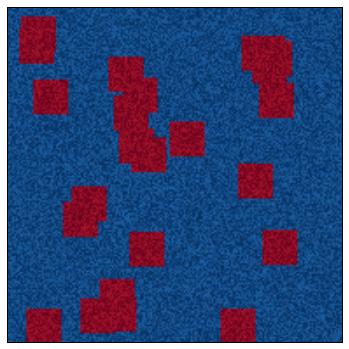

In [7]:
# set up animation frame
fig = pyplot.figure(figsize=(8,6))
pyplot.xticks([]), pyplot.yticks([]);

im = pyplot.imshow(Ui, cmap=cm.RdBu)

In [8]:
def init():
    im.set_data(Ui)
    return im,

def animate(data):
    im.set_array(data)
    return im,

In [9]:
# the first dimensionality of frames should be w.r.t time
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=Ut, interval=1)

In [10]:
HTML(anim.to_html5_video())